<td>
<a target="_blank" href="https://colab.research.google.com/github/renyuanL/handwritten-digit-recognition/blob/master/handwritten_digit_recognition_CPU.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run this in Google Colab</a>
</td>
 

- https://colab.research.google.com/github/renyuanL/handwritten-digit-recognition/blob/master/handwritten_digit_recognition_CPU.ipynb



# Handwritten Digit Recognition
## 手寫數字辨識

- Authors= 
    - Amitrajit Bose, 
    - Renyuan Lyu from CGU, Taiwan
- Dataset= MNIST
- [Medium Article Link](https://medium.com/@amitrajit_bose/handwritten-digit-mnist-pytorch-977b5338e627)
- Frameworks = PyTorch


### Necessary Imports

In [1]:
# Import necessary packages
# 引入(import) 必要的模組 (modules)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

In [2]:
import os
#from google.colab import drive

### Download The Dataset & Define The Transforms

In [3]:
# 蒐集、下載、整理 手寫數字資料 (MNIST)，以供實驗
# 第一次執行較花時間，第2次以後可關閉下載功能，以節省時間。

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset= datasets.MNIST('drive/My Drive/mnist/MNIST_data/', 
                         download= True,  # 第一次執行須 True, 以後就可改為False
                         train=True, 
                         transform=transform)
valset=   datasets.MNIST('drive/My Drive/mnist/MNIST_data/', 
                         download= True, 
                         train=False, transform=transform)

trainloader= torch.utils.data.DataLoader(trainset, 
                                         batch_size=64, 
                                         shuffle=True)
valloader=   torch.utils.data.DataLoader(valset,   
                                         batch_size=64, 
                                         shuffle=True)

### Exploring The Data

In [4]:
# 觀賞一下資料庫

dataiter= iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


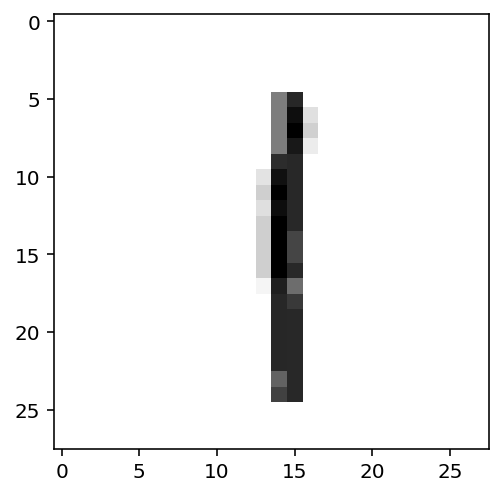

In [5]:
x= images[0].numpy().squeeze()
plt.imshow(x, cmap='gray_r');

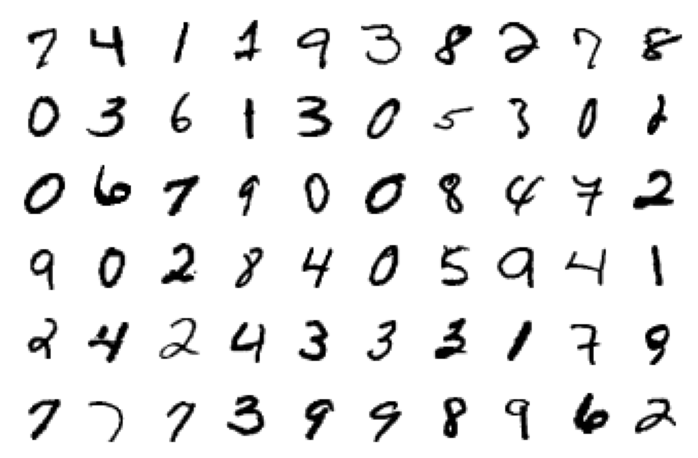

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    x= images[index].numpy().squeeze()
    plt.imshow(x, cmap='gray_r')

### Defining The Neural Network

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

In [7]:
# 定義 神經網路的架構參數

from torch import nn

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [8]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 7


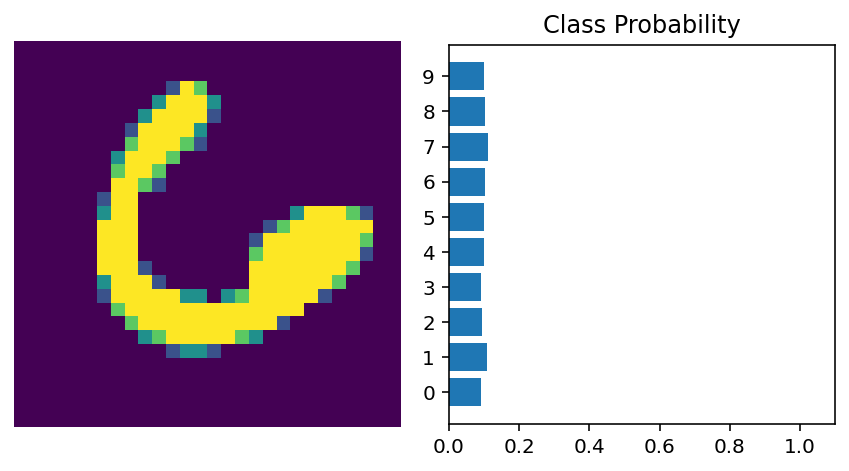

In [9]:
# 在訓練之前，先測試一下辨識效能：

images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [10]:
# 全面測試辨識效能

correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.1411


In [11]:
# 開始準備訓練

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [12]:
loss, logps 

(tensor(2.3253, grad_fn=<NllLossBackward>),
 tensor([[-2.4027, -2.1739, -2.3918, -2.4229, -2.2147, -2.2707, -2.2936, -2.2568,
          -2.3284, -2.3007],
         [-2.4107, -2.1876, -2.4245, -2.4631, -2.2890, -2.3187, -2.3148, -2.1691,
          -2.1746, -2.3239],
         [-2.4312, -2.1756, -2.3803, -2.5095, -2.1850, -2.3217, -2.2820, -2.1987,
          -2.2611, -2.3345],
         [-2.4024, -2.2005, -2.4031, -2.4764, -2.1796, -2.2678, -2.3176, -2.2370,
          -2.2397, -2.3448],
         [-2.4852, -2.2242, -2.3900, -2.4858, -2.2722, -2.3642, -2.2365, -2.0699,
          -2.2110, -2.3652],
         [-2.5005, -2.1229, -2.4080, -2.5700, -2.2002, -2.3020, -2.2613, -2.2219,
          -2.2450, -2.2793],
         [-2.4421, -2.1902, -2.2853, -2.5836, -2.2232, -2.2984, -2.2608, -2.2218,
          -2.3079, -2.2725],
         [-2.4271, -2.2899, -2.4198, -2.4258, -2.1964, -2.2978, -2.2731, -2.1414,
          -2.2116, -2.3926],
         [-2.4036, -2.1906, -2.3810, -2.5191, -2.2746, -2.2936, -2.3

In [13]:
print(f'Before backward pass: weight= {model[0].weight},\n weightGrad= {model[0].weight.grad}\n')

Before backward pass: weight= Parameter containing:
tensor([[ 0.0330, -0.0340,  0.0226,  ...,  0.0201, -0.0265,  0.0083],
        [-0.0176, -0.0231, -0.0062,  ..., -0.0281, -0.0297,  0.0268],
        [ 0.0207, -0.0032,  0.0025,  ...,  0.0092, -0.0280,  0.0036],
        ...,
        [ 0.0172,  0.0353, -0.0102,  ..., -0.0191,  0.0170, -0.0214],
        [ 0.0005, -0.0191, -0.0110,  ..., -0.0111, -0.0277,  0.0064],
        [ 0.0177, -0.0035, -0.0299,  ..., -0.0225,  0.0175, -0.0290]],
       requires_grad=True),
 weightGrad= None



In [14]:
loss.backward()

# 執行 .backward() 之後， weight 本身不變，但 weightGrad 被更新了！
print(f'Before backward pass: weight= {model[0].weight},\n weightGrad= {model[0].weight.grad}\n')

Before backward pass: weight= Parameter containing:
tensor([[ 0.0330, -0.0340,  0.0226,  ...,  0.0201, -0.0265,  0.0083],
        [-0.0176, -0.0231, -0.0062,  ..., -0.0281, -0.0297,  0.0268],
        [ 0.0207, -0.0032,  0.0025,  ...,  0.0092, -0.0280,  0.0036],
        ...,
        [ 0.0172,  0.0353, -0.0102,  ..., -0.0191,  0.0170, -0.0214],
        [ 0.0005, -0.0191, -0.0110,  ..., -0.0111, -0.0277,  0.0064],
        [ 0.0177, -0.0035, -0.0299,  ..., -0.0225,  0.0175, -0.0290]],
       requires_grad=True),
 weightGrad= tensor([[-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [ 0.0014,  0.0014,  0.0014,  ...,  0.0014,  0.0014,  0.0014],
        [ 0.0008,  0.0008,  0.0008,  ...,  0.0008,  0.0008,  0.0008],
        ...,
        [-0.0008, -0.0008, -0.0008,  ..., -0.0008, -0.0008, -0.0008],
        [-0.0015, -0.0015, -0.0015,  ..., -0.0015, -0.0015, -0.0015],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004]])



In [15]:
# 指定 Optimization 的演算法為 SGD (Stochastic Gradient Decent)

from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [16]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 0.0330, -0.0340,  0.0226,  ...,  0.0201, -0.0265,  0.0083],
        [-0.0176, -0.0231, -0.0062,  ..., -0.0281, -0.0297,  0.0268],
        [ 0.0207, -0.0032,  0.0025,  ...,  0.0092, -0.0280,  0.0036],
        ...,
        [ 0.0172,  0.0353, -0.0102,  ..., -0.0191,  0.0170, -0.0214],
        [ 0.0005, -0.0191, -0.0110,  ..., -0.0111, -0.0277,  0.0064],
        [ 0.0177, -0.0035, -0.0299,  ..., -0.0225,  0.0175, -0.0290]],
       requires_grad=True)
Gradient - tensor([[ 0.0017,  0.0017,  0.0017,  ...,  0.0017,  0.0017,  0.0017],
        [ 0.0018,  0.0018,  0.0018,  ...,  0.0018,  0.0018,  0.0018],
        [ 0.0020,  0.0020,  0.0020,  ...,  0.0020,  0.0020,  0.0020],
        ...,
        [-0.0008, -0.0008, -0.0008,  ..., -0.0008, -0.0008, -0.0008],
        [-0.0008, -0.0008, -0.0008,  ..., -0.0008, -0.0008, -0.0008],
        [-0.0024, -0.0024, -0.0024,  ..., -0.0024, -0.0024, -0.0024]])


In [17]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)


Updated weights -  Parameter containing:
tensor([[ 0.0330, -0.0340,  0.0225,  ...,  0.0200, -0.0265,  0.0083],
        [-0.0176, -0.0232, -0.0062,  ..., -0.0281, -0.0298,  0.0268],
        [ 0.0207, -0.0032,  0.0025,  ...,  0.0092, -0.0280,  0.0035],
        ...,
        [ 0.0172,  0.0353, -0.0102,  ..., -0.0191,  0.0170, -0.0213],
        [ 0.0005, -0.0191, -0.0110,  ..., -0.0111, -0.0277,  0.0064],
        [ 0.0177, -0.0035, -0.0298,  ..., -0.0225,  0.0176, -0.0290]],
       requires_grad=True)


### Core Training Of Neural Network

In [18]:
optimizer = optim.SGD(model.parameters(), 
                      lr= 0.003, 
                      momentum= 0.9)

time0 = time() # 監控一下時間，記錄當前時間

epochs= 15  # 這個 epochs 可改小，以免跑太久，但若要提升辨識率，則應該改大一點。

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vectors
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {e} - Training loss: {running_loss/len(trainloader)}")
    print(f"Acc Training Time (in minutes)= {(time()-time0)/60:.3f}\n")


Epoch 0 - Training loss: 0.6354379079489312
Acc Training Time (in minutes)= 0.146

Epoch 1 - Training loss: 0.28545953772628485
Acc Training Time (in minutes)= 0.284

Epoch 2 - Training loss: 0.22583072225867049
Acc Training Time (in minutes)= 0.424

Epoch 3 - Training loss: 0.18150838159882565
Acc Training Time (in minutes)= 0.572

Epoch 4 - Training loss: 0.15096781201072848
Acc Training Time (in minutes)= 0.712

Epoch 5 - Training loss: 0.13017348505095885
Acc Training Time (in minutes)= 0.849

Epoch 6 - Training loss: 0.11486188656807358
Acc Training Time (in minutes)= 0.984

Epoch 7 - Training loss: 0.10108183017933864
Acc Training Time (in minutes)= 1.127

Epoch 8 - Training loss: 0.09241680443874681
Acc Training Time (in minutes)= 1.269

Epoch 9 - Training loss: 0.08331822222178138
Acc Training Time (in minutes)= 1.413

Epoch 10 - Training loss: 0.07649393271364922
Acc Training Time (in minutes)= 1.552

Epoch 11 - Training loss: 0.06909839922327922
Acc Training Time (in minutes)

Predicted Digit = 0


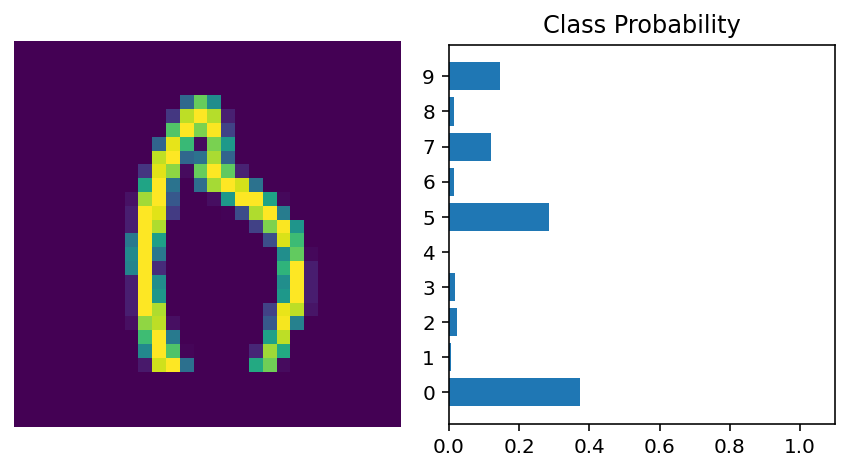

In [19]:
# 訓練後，再測試一下辨識效能：

images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

### Model Evaluation

In [20]:
# 訓練後，全面測試辨識效能

correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9755
